In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import xgboost as xgb
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import mean_squared_log_error

### Import Data

In [3]:
train_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\train.csv",parse_dates=['date'])
test_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\test.csv",parse_dates=['date']) 
holidays_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\holidays_events.csv",parse_dates=['date']) 
oil_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\oil.csv",parse_dates=['date']) 
stores_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\stores.csv")
transactions_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\transactions.csv",parse_dates=['date'])

### Missing Values Data

In [4]:
df = pd.concat([train_df, test_df], sort=True) #3029400
df = df.merge(oil_df, on='date', how='left')
df = df.merge(stores_df, on='store_nbr', how='left')
df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

In [5]:
print('Shape of data: \t', df.shape)

Shape of data: 	 (3029400, 12)


In [6]:
df.isnull().sum()

date                 0
family               0
id                   0
onpromotion          0
sales            28512
store_nbr            0
dcoilwtico      935550
city                 0
state                0
type                 0
cluster              0
transactions    274296
dtype: int64

In [7]:
df.state.unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [8]:
complete_dates = df.date.unique()
df_oil_dates = pd.DataFrame(complete_dates)
df_oil_dates = df_oil_dates.rename(columns={0:'date'})

df_moving_avg_oil = df_oil_dates.merge(oil_df, on=['date'], how='left')
df_moving_avg_oil.dcoilwtico.bfill(axis ='rows', inplace=True)

df_moving_avg_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

Text(0.5, 1.0, 'Oil Prices in Ecuador')

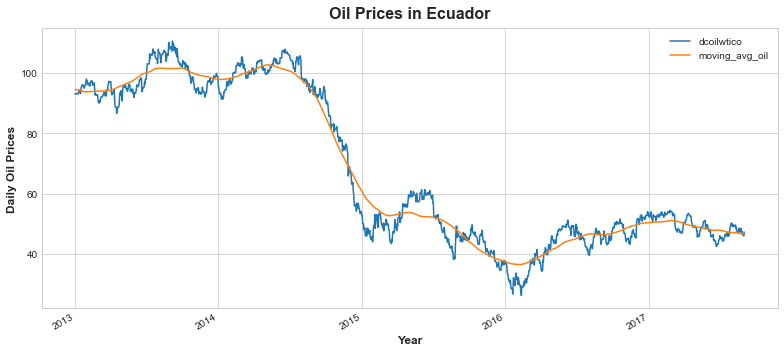

In [9]:
df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil.rolling(
    window=180,       # Tested a couple window sizes to ensure bfill would result in zero null values
    center=True,      # puts the average at the center of the window
    min_periods=90,   # choose about half the window size
).mean()              # compute the mean

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

df_moving_avg_oil['Year'] = df_moving_avg_oil['date'].dt.year

df_moving_avg_oil.plot.line(x='date', y=['dcoilwtico', 'moving_avg_oil'])

plt.xlabel('Year')
plt.ylabel('Daily Oil Prices')
plt.title("Oil Prices in Ecuador")

#plt.show();

In [10]:
df = df.drop('dcoilwtico', axis=1)

df_moving_avg_oil=df_moving_avg_oil.drop(columns=['dcoilwtico','Year'])
df['date'] = pd.to_datetime(df['date'])
df = df.merge(df_moving_avg_oil, on='date', how='left')

In [11]:
#df = df.set_index('date').to_period('D') #important to set the period frequency to get out_of_sample forecast dates after origin

In [12]:
df['transactions'] = df['transactions'].replace(np.nan, int(0))
df['sales'] = df['sales'].replace(np.nan, int(0))

#df.isnull().sum()
#df.dtypes

date              0
family            0
id                0
onpromotion       0
sales             0
store_nbr         0
city              0
state             0
type              0
cluster           0
transactions      0
moving_avg_oil    0
dtype: int64

In [14]:
X1_df = df.copy()
X1_df.drop(columns=['onpromotion','city', 'state', 'type','cluster', 'transactions', 'moving_avg_oil', 'id'], inplace=True)
X1_df = X1_df.loc[:len(train_df), :]

X1_df = X1_df.set_index('date').to_period('D') 

#X2_df = df.copy()
#X2_df.drop(columns=['sales', 'onpromotion'])

In [15]:
X1_df = X1_df.reset_index()
X1_df = X1_df.set_index(['store_nbr', 'family', 'date']).sort_index()

In [16]:
X1_avg = (X1_df.groupby('date').mean().squeeze())
y = X1_df.unstack(['store_nbr', 'family']).fillna(0.0)

In [17]:
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=3,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X1_dp = dp.in_sample()

In [56]:
X1_dp

,const,trend,trend_squared,trend_cubed,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,1.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,4.0,8.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2013-01-03,1.0,3.0,9.0,2.700000e+01,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2013-01-04,1.0,4.0,16.0,6.400000e+01,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2013-01-05,1.0,5.0,25.0,1.250000e+02,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-12,1.0,1681.0,2825761.0,4.750104e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,1682.0,2829124.0,4.758587e+09,1.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139
2017-08-14,1.0,1683.0,2832489.0,4.767079e+09,0.0,1.0,0.0,0.0,0.0,0.0,0.485302,-0.874347,-0.848644,0.528964,0.998717,-0.050649,-0.897805,-0.440394


In [18]:
holidays = holidays_df.copy()
holidays = holidays.set_index('date').to_period('D')
#Select national and regional holidays for 2017
holidays = holidays.loc[(holidays.locale.isin(['Regional','National'])) & (holidays.type.isin(['Transfer','Bridge','Holiday'])) ]
#holidays = holidays.loc['2016',:]
holidays = holidays.loc[(holidays.transferred == False)]
holidays = holidays.loc['2013-01-01':'2017-08-15',:]
print('Shape of holidays: \t', holidays.shape)
holidays.reset_index(inplace=True)

Shape of holidays: 	 (72, 5)


In [19]:
holidays = holidays.loc[:,['date','type','description']]
holidays 

,date,type,description
0,2013-01-01,Holiday,Primer dia del ano
1,2013-02-11,Holiday,Carnaval
2,2013-02-12,Holiday,Carnaval
3,2013-04-01,Holiday,Provincializacion de Cotopaxi
4,2013-04-29,Holiday,Viernes Santo
...,...,...,...
67,2017-04-14,Holiday,Viernes Santo
68,2017-05-01,Holiday,Dia del Trabajo
69,2017-05-26,Transfer,Traslado Batalla de Pichincha
70,2017-06-25,Holiday,Provincializacion de Imbabura


In [20]:
i = 0
split_description = dict()
d_index = []
types=['Transfer','Bridge']

for i in range(len(holidays)):
    if (holidays.type[i] in types):
        s = holidays.loc[i, 'description']
        split_description[i] = s.split(maxsplit=1)[1]
        d_index.append(i)
print(d_index)


[9, 24, 30, 32, 53, 55, 59, 63, 69, 71]


In [21]:
for d in d_index:
    holidays.description[d] = split_description[d]

C:\Users\adeli\AppData\Local\Temp/ipykernel_7132/707356888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays.description[d] = split_description[d]


In [22]:
X_holidays = pd.get_dummies(holidays['description'])
X_holidays.index = holidays.date

In [59]:
X_holidays

,Batalla de Pichincha,Carnaval,Dia de Difuntos,Dia del Trabajo,Independencia de Cuenca,Independencia de Guayaquil,Navidad,Primer Grito de Independencia,Primer dia del ano,Provincializacion Santa Elena,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Provincializacion de Santo Domingo,Viernes Santo
date,,,,,,,,,,,,,,
2013-01-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2013-02-11,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-12,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2013-04-29,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-14,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-05-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2017-05-26,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
X1_dph = X1_dp.join(X_holidays, on='date').fillna(0.0)
m=X1_dp.shape[1]+X_holidays.shape[1]
print(f"Check for expected shape (1685, {m})",X1_dph.shape)

Check for expected shape (1685, 32) (1685, 32)


In [24]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_dph_train, X1_dph_valid = X1_dph[: "2017-07-01"], X1_dph["2017-07-02" :]
y_valid = y_valid.stack(['store_nbr', 'family']).groupby('date').mean().squeeze()

model = LinearRegression(fit_intercept=False)
model.fit(X1_dph_train, y_train)
y_fit_X1_dph = pd.DataFrame(model.predict(X1_dph_train), index=X1_dph_train.index, columns=y.columns)
y_pred_X1_dph = pd.DataFrame(model.predict(X1_dph_valid), index=X1_dph_valid.index, columns=y.columns)

In [25]:
#2017
y_train_2017 = y.loc['2017-01-01':'2017-07-01',:]
X1_dph_train_2017 = X1_dph.loc['2017-01-01':'2017-07-01',:]

In [26]:
model_2017 = LinearRegression(fit_intercept=False)
model_2017.fit(X1_dph_train_2017, y_train_2017)
y_pred_X1_dph_2017 = pd.DataFrame(model_2017.predict(X1_dph_valid), index=X1_dph_valid.index, columns=y.columns)

In [35]:
y_fit_X1_dph = y_fit_X1_dph.stack(['store_nbr', 'family']).groupby('date').mean().squeeze()
y_train = y_train.stack(['store_nbr', 'family']).groupby('date').mean().squeeze()
y_pred_X1_dph_2017 = y_pred_X1_dph_2017.stack(['store_nbr', 'family']).groupby('date').mean().squeeze()
y_pred_X1_dph = y_pred_X1_dph.stack(['store_nbr', 'family']).groupby('date').mean().squeeze()

# Prediction w/Rolling Averages

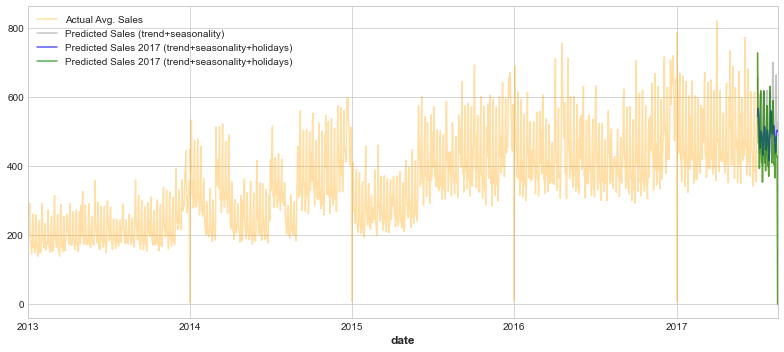

In [28]:
ax = X1_avg.plot(color='orange', alpha=0.35, label='Actual Avg. Sales')
y_pred_X1_dph_2017.plot(ax=ax, color='gray', alpha=0.45, label='Predicted Sales (trend+seasonality)')
y_pred_X1_dph.plot(ax=ax, color='blue', alpha=0.65, label='Predicted Sales 2017 (trend+seasonality+holidays)')
y_valid.plot(ax=ax, color='green', alpha=0.65, label='Predicted Sales 2017 (trend+seasonality+holidays)')
ax.legend()

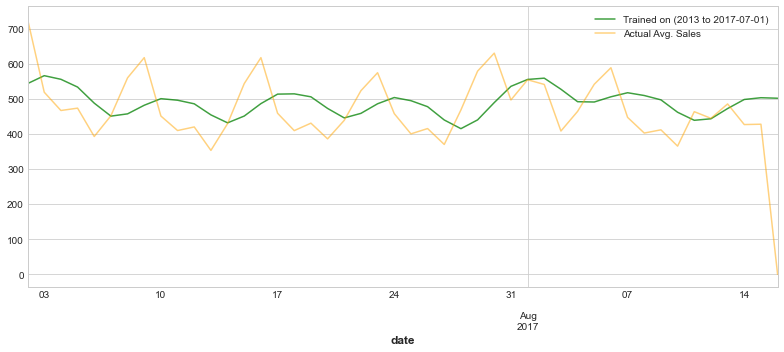

In [30]:
#y_pred_2017 = y_pred.loc['2017-07-02':]

#ax = y_pred_X1_dph_2017.plot(label='Trained on (2017 to 2017-07-01)', color='blue')
ax = y_pred_X1_dph.plot(color='green', alpha=0.75, label='Trained on (2013 to 2017-07-01)')
y_valid.plot(ax=ax, color='orange', alpha=0.5, label='Actual Avg. Sales')
ax.legend()

In [ ]:
rmse = sqrt(mean_squared_log_error(y_pred_X1_dph, y_valid))
rmse_2017 = sqrt(mean_squared_log_error(y_pred_X1_dph_2017, y_valid))

print('rmse:', rmse)
print('rmse_2017:', rmse_2017)

In [37]:
y_resid = y_train - y_fit_X1_dph

<AxesSubplot:xlabel='date'>

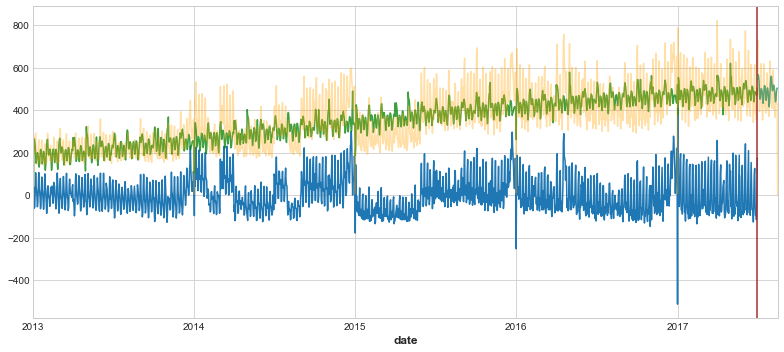

In [55]:
ax = y_resid.plot()
y_fit_X1_dph.plot(ax=ax, color='green', alpha=0.75, label='')
X1_avg.plot(ax= ax, color='orange', alpha=0.35, label='Actual Avg. Sales')
ax.axvline(x='2017-07-01', ymin=-400, ymax=600, color='brown')
y_pred_X1_dph.plot(ax=ax, color='seagreen', alpha=0.75, label='Trained on (2013 to 2017-07-01)')